# Classificação para dados de usuários do Moodle

**Nota: Por questões de privacidade, as tabelas foram ocultadas, assim este caderno pode ser mantido público sem expôr informações sensíveis de quaisquer usuários.**

Métodos de Machine Learning aplicados aos dados de uso de um ambiente do Moodle da USP

**Problema**: Existem agrupamentos de usuários que utilizam o Moodle? Seria possível "classificá-los"? Se sim, seria possível identificar tendências aos grupos? <br>
**Objetivo**: Aplicar um método de *clustering* ao arquivo de logs, e responder às perguntas acima.

### Lista de verificação do projeto
- [X] Foque no problema e no quadro geral;
- [X] Obtenha os dados;
- [X] Explore os dados para obter insights;
- [X] Prepare os dados para melhor expor os padrões de dados subjacentes aos algoritmos de Machine Learning;
- [X] Explore e ajuste seu modelo em uma boa solução;
- [X] Apresente sua solução

## Obter dados

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.min_rows', 50)

logs = pd.read_csv('logs-66769.csv')

In [2]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217650 entries, 0 to 217649
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         217650 non-null  int64  
 1   id                 217650 non-null  int64  
 2   eventname          217650 non-null  object 
 3   component          217650 non-null  object 
 4   action             217650 non-null  object 
 5   target             217650 non-null  object 
 6   objecttable        175219 non-null  object 
 7   objectid           175219 non-null  float64
 8   crud               217650 non-null  object 
 9   edulevel           217650 non-null  int64  
 10  contextid          217650 non-null  int64  
 11  contextlevel       217650 non-null  int64  
 12  contextinstanceid  217650 non-null  int64  
 13  userid             217650 non-null  int64  
 14  courseid           217650 non-null  int64  
 15  relateduserid      121190 non-null  float64
 16  an

## Explorar

**Colunas previsivelmente de interesse:** <br>
action: Ação <br>
crud: Respectivamente: create, read, upload, e delete <br>
edulevel: Professor ou aluno **(?) não tenho certeza** <br>
userid: ID único do usuário <br>
timecreated: Hora da ação <br>
origin: Dispositivo usado na ação <br>

**Quantos usuários há no ambiente?**

In [3]:
print(logs['userid'].nunique(), 'usuários')

224 usuários


**Quantas ações há no total?**

In [4]:
print('Há',len(logs) ,'ações')

Há 217650 ações


Visualização de ações por tipo crud (create, read, upload e delete):

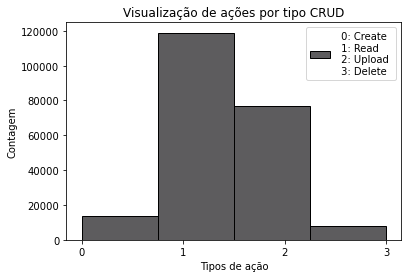

In [5]:
import seaborn as sns
sns.set_palette(sns.dark_palette("muted purple", input="xkcd"))
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

crud = logs['crud'].replace(logs['crud'].unique(), np.arange(len(logs['crud'].unique())))
        
ax = sns.histplot(crud, bins=4, kde=False, label=' 0: Create \n 1: Read \n 2: Upload \n 3: Delete')
plt.title('Visualização de ações por tipo CRUD')
plt.xlabel('Tipos de ação')
plt.ylabel('Contagem')
plt.xticks((0,1,2,3))
plt.legend()
plt.show()

Há consideravelmente mais ações do tipo read (esperado) e upload do que create ou delete.

**Quais as três ações mais comuns?**

In [7]:
logs['action'].value_counts().head(3)

viewed     113179
graded      59453
updated     11677
Name: action, dtype: int64

Aparentemente, ações mais comuns são de visualização, dar nota e atualizar conteúdo.

**Quais os horários de maior ação?**

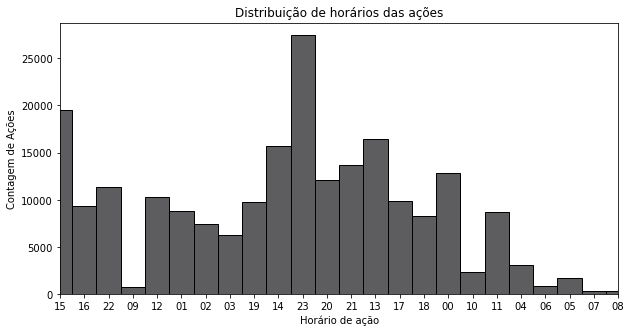

In [8]:
hours = [(i.split()[1][:2]) for i in logs['timecreated']]

plt.figure(figsize=(10,5))
ax = sns.histplot(hours, bins=24, kde=False)

plt.xlim(0,23)
plt.xticks(np.arange(0,24))
plt.title('Distribuição de horários das ações')
plt.xlabel('Horário de ação')
plt.ylabel('Contagem de Ações')

plt.show()

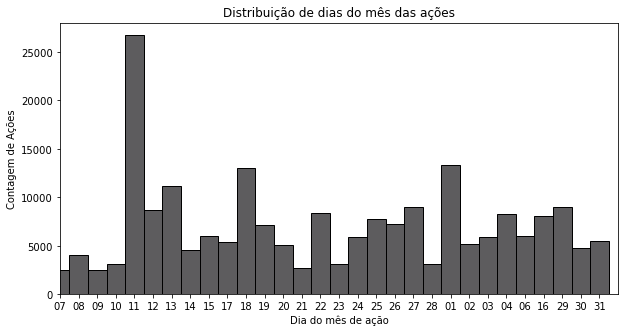

In [9]:
days = [(i.split()[0][8:10]) for i in logs['timecreated']]

plt.figure(figsize=(10,5))
ax = sns.histplot(days, bins=30, kde=False)

plt.xlim(1,31)
plt.xticks(np.arange(1,31))
plt.title('Distribuição de dias do mês das ações')
plt.xlabel('Dia do mês de ação')
plt.ylabel('Contagem de Ações')

plt.show()

Aparentemente os horários de ação são sobretudo antes da meia-noite (provavelmente pelo limite imposto pelo professor para entrega de trabalhos), logo após a meia-noite (talvez trabalhos atrasados), e após o horário de almoço (primeiro horário livre para alunos do período diurno). <br> O período da manhã não possui ações, por ser uma turma diurna.<br>
Além disso, há mais ações perto dos 12º dias do mês, por motivo desconhecido, porém pode-se especular que seja um dia estabelecido pelo professor para realizar entrega de trabalhos.


**Qual dispositivo mais usado?**

In [10]:
logs['origin'].value_counts()

web        191609
cli         16998
ws           8962
restore        81
Name: origin, dtype: int64

Web é largamento mais usado

## Preparar dados

Separar colunas que serão usadas

In [11]:
data = logs[['action', 'crud', 'edulevel', 'timecreated', 'origin', 'userid']]

Mudar as strings para números para serem tratados

In [12]:
pd.options.mode.chained_assignment = None 

data['action'] = data['action'].replace(data['action'].unique(), np.arange(len(data['action'].unique())))
data['crud'] = data['crud'].replace(data['crud'].unique(), np.arange(len(data['crud'].unique())))
data['origin'] = data['origin'].replace(data['origin'].unique(), np.arange(len(data['origin'].unique())))

Para lidar com o tempo, primeiro, vamos separar por dia, mês e hora da ação.

In [13]:
day = pd.Series([int(i.split()[0][8:]) for i in data['timecreated']])
month = pd.Series([int(i.split()[0][5:7]) for i in data['timecreated']])
hour = pd.Series([int(i.split()[1][:2]) for i in data['timecreated']])

data['day'] = day
data['month'] = month
data['hour'] = hour

Converter timecreated para timestamp

In [14]:
import time
import datetime

time = [
    time.mktime(datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").timetuple())
    for i in data['timecreated']
]

data['timecreated'] = time

Criar dataframe separado por usuário

In [15]:
data_per_user = data.set_index('userid').stack().to_frame()
data_per_user.columns = ['Logs']

A tabela abaixo cria uma tabela mostrando informações para cada usuário. <br>
Cada coluna mostra, respectivamente: ID de usuário, ação mais comum, contagem de create, contagem de read, contagem de upload, contagem de delete, edulevel mais comum, dispositivo mais comum, hora mais comum, mês mais comum, dia mais comum.

In [16]:
user_list = pd.DataFrame()

for user in data['userid'].unique():
    action = data[data['userid']==user]['action'].value_counts().index[0]
    try: 
        create = data[data['userid']==user]['crud'].value_counts()[0]
    except:
        create = 0
    try: 
        read = data[data['userid']==user]['crud'].value_counts()[1]
    except:
        read = 0
    try: 
        upload = data[data['userid']==user]['crud'].value_counts()[2]
    except:
        upload = 0
    try: 
        delete = data[data['userid']==user]['crud'].value_counts()[3]
    except:
        delete = 0
    edulevel = data[data['userid']==user]['edulevel'].value_counts().index[0]
    origin = data[data['userid']==user]['origin'].value_counts().index[0]
    hour = data[data['userid']==user]['hour'].value_counts().index[0]
    month = data[data['userid']==user]['month'].value_counts().index[0]
    day = data[data['userid']==user]['day'].value_counts().index[0]

    user_list = user_list.append([[user, action, create, read, upload, delete, edulevel, origin, hour, month, day]])

user_list.columns = ['userid', 'action', 'create', 'read', 'upload', 'delete', 
                                  'edulevel', 'origin', 'hour', 'month', 'day']
user_list.reset_index(inplace=True)
user_list.drop('index', axis=1, inplace=True)

Os usuários de ID 2 e -1 parecem ser ferramentas do sistema ou admins da plataforma ao invés de usuários, vamos retirá-los.

In [17]:
user_list = user_list.drop([1,2], axis=0)
user_list = user_list.reset_index()
user_list = user_list.drop('index', axis=1)

Agora, vamos separar nosso cluster em dois tipos: <br>
Vamos separar os usuários por tipo CRUD, e por tempo de ação

In [18]:
user_action = user_list[['create', 'read', 'upload', 'delete']]
user_time = user_list[['hour', 'month', 'day']]

Todos os dados foram convertidos para números e tratados, os dados podem ser inseridos devidamente

## Treinamento de modelos

Modelo escolhido: k-Means

### k-Means

Primeiro, vamos fazer um cluster para dados do tipo de conteúdo criado

#### Análise de tipos CRUD de ação realizada

In [19]:
X_users = [list(
    user_action.loc[i]
) for i in range(0, len(user_action))]
X_users[:5]

[[1687, 4255, 3693, 6291],
 [150, 1019, 3673, 13],
 [0, 1, 0, 0],
 [0, 5, 0, 0],
 [71, 914, 99, 0]]

Qual o número de clusters a utilizar? Utilizaremos o método sse, vendo onde fica a inflexão do gráfico

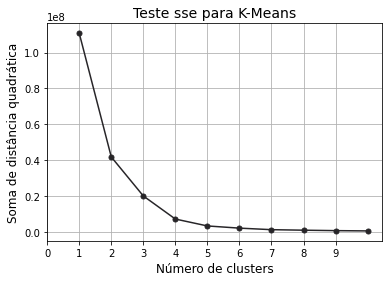

In [21]:
from sklearn.cluster import KMeans

sse = []
list_k = list(range(1, 11))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_users)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(list_k, sse, marker='.', markersize=10)
plt.title('Teste sse para K-Means', size=14)
plt.xlabel('Número de clusters', size=12)
plt.ylabel('Soma de distância quadrática', size=12)
plt.xticks(np.arange(0,10))
plt.grid()

plt.show()

Vemos que o número de cluster mais adequado parece estar entre 2 e 4. Iremos utilizar 3.

In [22]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_users)
y_pred = kmeans.predict(X_users)
y_pred = y_pred.reshape(37,6)

Visualizar predições

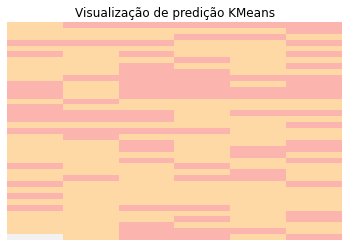

In [23]:
plt.figure(1)
plt.clf()
plt.axes(None)
plt.imshow(y_pred, interpolation='nearest',
           cmap=plt.cm.Pastel1,
           aspect='auto', origin='lower')

plt.axis('off')
plt.title('Visualização de predição KMeans')
plt.show()

Visualizar centros dos clusters

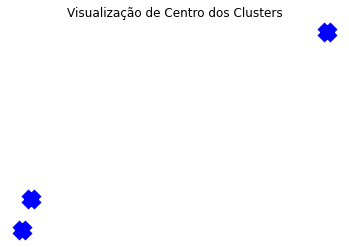

In [24]:
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=10,
            color='b', zorder=10)
plt.title('Visualização de Centro dos Clusters')
plt.axis('off')
plt.show()

Adicionar predição à tabela

In [25]:
user_action['Kmeans_pred']= kmeans.predict(X_users)
user_action.head()

,create,read,upload,delete,Kmeans_pred
0,1687,4255,3693,6291,2
1,150,1019,3673,13,1
2,0,1,0,0,0
3,0,5,0,0,0
4,71,914,99,0,1


Vamos visualizar os clusters separando por cada parâmetro:

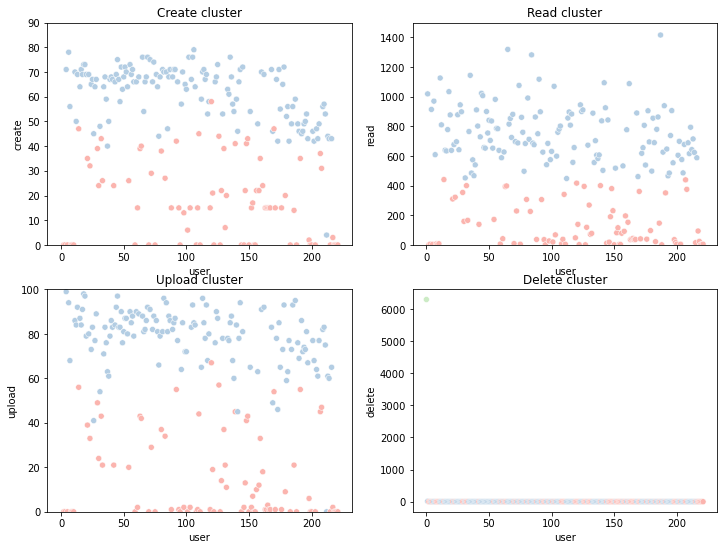

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(12,9))

sns.scatterplot(x=user_action.index, y='create', data=user_action, hue='Kmeans_pred', palette='Pastel1', ax=axs[0,0])
axs[0, 0].set_ylim(0,90)
axs[0, 0].set_xlabel('user')
axs[0, 0].set_title('Create cluster')
axs[0, 0].get_legend().remove()


sns.scatterplot(x=user_action.index, y='read', data=user_action, hue='Kmeans_pred', palette='Pastel1', ax=axs[0,1])
axs[0, 1].set_ylim(0,1500)
axs[0, 1].set_xlabel('user')
axs[0, 1].set_title('Read cluster')
axs[0, 1].get_legend().remove()

sns.scatterplot(x=user_action.index, y='upload', data=user_action, hue='Kmeans_pred', palette='Pastel1', ax=axs[1,0])
axs[1, 0].set_ylim(0,100)
axs[1, 0].set_xlabel('user')
axs[1, 0].set_title('Upload cluster')
axs[1, 0].get_legend().remove()

sns.scatterplot(x=user_action.index, y='delete', data=user_action, hue='Kmeans_pred', palette='Pastel1', ax=axs[1,1])
axs[1,1].set_xlabel('user')
axs[1, 1].set_title('Delete cluster')
axs[1, 1].get_legend().remove()

plt.show()

Parece que o cluster identificou duas classes de usuários: Aqueles que contribuem muito e que contribuem pouco.

Vamos adicionar as previsões à planilha geral

In [27]:
user_list['crud_pred'] = user_action['Kmeans_pred']

Vamos fazer a mesma coisa, mas agora com dados de tempo.

#### Análise de dados de tempo

In [28]:
X_users = [list(
    user_time.loc[i]
) for i in range(0, len(user_action))]
X_users[:5]

[[15, 4, 18], [21, 4, 25], [22, 2, 5], [3, 2, 9], [0, 5, 12]]

Descobrir número de k a utilizar:

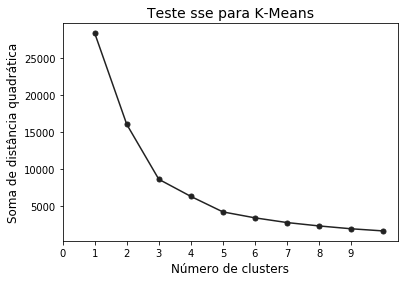

In [27]:
from sklearn.cluster import KMeans

sse = []
list_k = list(range(1, 11))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_users)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(list_k, sse, marker='.', markersize=10)
plt.title('Teste sse para K-Means', size=14)
plt.xlabel('Número de clusters', size=12)
plt.ylabel('Soma de distância quadrática', size=12)
plt.xticks(np.arange(0,10))

plt.show()

Iremos utilizar 3 novamente

In [39]:
kmeans = KMeans(n_clusters=3, random_state=51)
kmeans.fit(X_users)
y_pred = kmeans.predict(X_users)
y_pred = y_pred.reshape(37,6)

Visualização das predições:

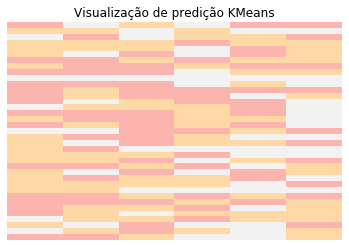

In [40]:
plt.figure(1)
plt.clf()
plt.axes(None)
plt.imshow(y_pred, interpolation='nearest',
           cmap=plt.cm.Pastel1,
           aspect='auto', origin='lower')

plt.axis('off')
plt.title('Visualização de predição KMeans')
plt.show()

Visualização dos centros:

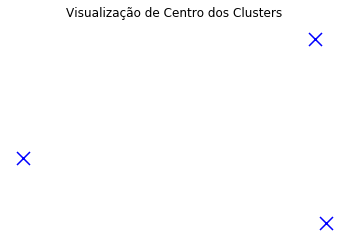

In [41]:
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=10,
            color='b', zorder=10)
plt.title('Visualização de Centro dos Clusters')
plt.axis('off')
plt.show()

Predição:

In [42]:
user_time['Kmeans_pred']= kmeans.predict(X_users)
user_time.head()

,hour,month,day,Kmeans_pred
0,15,4,18,0
1,21,4,25,0
2,22,2,5,1
3,3,2,9,2
4,0,5,12,2


Gráficos de cluster por parâmetro:

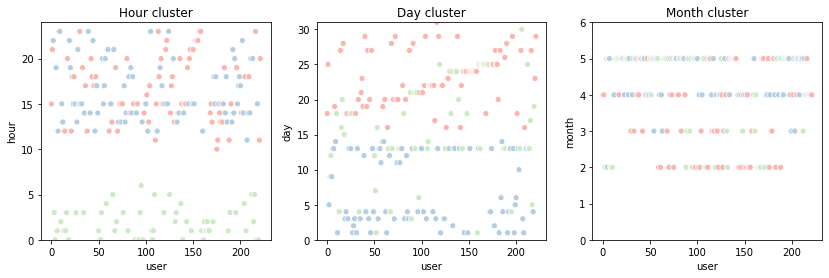

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(14,4))

sns.scatterplot(x=user_time.index, y='hour', data=user_time, hue='Kmeans_pred', palette='Pastel1', ax=axs[0])
axs[0].set_ylim(0,24)
axs[0].set_xlabel('user')
axs[0].set_title('Hour cluster')
axs[0].get_legend().remove()

sns.scatterplot(x=user_time.index, y='day', data=user_time, hue='Kmeans_pred', palette='Pastel1', ax=axs[1])
axs[1].set_ylim(0,31)
axs[1].set_xlabel('user')
axs[1].set_title('Day cluster')
axs[1].get_legend().remove()

sns.scatterplot(x=user_time.index, y='month', data=user_time, hue='Kmeans_pred', palette='Pastel1', ax=axs[2])
axs[2].set_ylim(0,6)
axs[2].set_xlabel('user')
axs[2].set_title('Month cluster')
axs[2].get_legend().remove()

plt.show()

Adicionando previsões à planilha geral:

In [44]:
user_list['time_pred'] = user_time['Kmeans_pred']
user_list.head()

,userid,action,create,read,upload,delete,edulevel,origin,hour,month,day,crud_pred,time_pred
0,50211,9,1687,4255,3693,6291,1,0,15,4,18,2,0
1,156798,7,150,1019,3673,13,1,0,21,4,25,1,0
2,269832,3,0,1,0,0,2,0,22,2,5,0,1
3,214522,3,0,5,0,0,2,0,3,2,9,0,2
4,269997,3,71,914,99,0,2,0,0,5,12,1,2


#### Análise a partir dos clusters <br>
Vê-se que no primeiro caso, o algoritmo reconheceu dois grupos: Um para grandes contagens de ações de criação, leitura e envio (Create-Read-Upload), e outro para contagens menores. Como foi definido k=3, um terceiro grupo também existe, mas poucas instâncias foram atribuídas à ele, e não é possível visualizá-lo na figura acima, sendo provavelmente um dado anômalo. Presume-se que o algoritmo tenha identificado, para esta informação, dois tipos de usuários: aqueles com grande contribuição no Moodle, e com pouca contribuição. <br><br>
No segundo caso, os agrupamentos variam de acordo com a informação analisada (dia, mês ou horário de ação). Vê-se um primeiro grupo, representado pela cor vermelha, cujo horário de ação na plataforma Moodle varia entre 12 e 23 horas. Este grupo prefere usar o Moodle nos primeiros dias do mês, ou em dias à metade do mês. Por fim, este grupo utilizou a plataforma mais ao final do semestre (meses 4 e 5). Um segundo grupo, representado por azul, prefere utilizar o Moodle em horários noturnos, costuma realizar mais ações ao final do mês, e tem ações realizadas ao longo de todo o semestre. Um terceiro grupo, representado por verde, utiliza o Moodle em horários da madrugada, porém não há consistência neste grupo sobre o dia do mês ou o mês do ano que a ação é realizada. Considerando que a maior parte das contribuições ocorre perto da meia-noite, vê-se que os grupos vermelho e azul são mais ativos, em especial o grupo vermelho. Também vê-se que o grupo vermelho também contribui nos dias onde há maior contribuição. Assim, vê-se que o grupo vermelho é largamente aquele que mais realiza ações.<br><br>
Assim, temos duas predições, com cinco grupos de usuários. Para a primeira predição, temos um grupo de alunos que contribui com várias ações no Moodle, e outro que contribui com poucas ações. Para a segunda predição, temos três grupos. O primeiro utiliza o Moodle em horários vespertinos e noturnos, contribui em dias específicos do mês, e é mais ativo ao fim do semestre, sendo responsável pela maior parte de ações do Moodle. O segundo grupo utiliza o Moodle em horários noturnos, e ao final dos meses. O terceiro grupo utiliza o Moodle às madrugadas, e não tem consistência com dias ou meses de uso.


### Novo objetivo: Checar correlação entre esta classificação de alunos e notas.

Importar informação de notas dos alunos

In [45]:
grade = pd.read_csv('notas-66769-jupiter-cleaned.csv')
grade = grade.fillna(value=0)
grade = grade[['id', 'notfim']]
grade.columns = ['userid', 'grade']
grade.head()

,userid,grade
0,258440,0.0
1,266706,0.0
2,129917,0.0
3,267745,0.0
4,252690,0.0


Mesclando informações prévias com notas

In [46]:
user_all = pd.merge(user_list, grade, on='userid')
user_all.head()

,userid,action,create,read,upload,delete,edulevel,origin,hour,month,day,crud_pred,time_pred,grade
0,269997,3,71,914,99,0,2,0,0,5,12,1,2,7.5
1,270039,3,78,970,94,1,2,0,1,5,13,1,2,8.1
2,252418,3,56,609,68,0,2,0,12,5,13,1,1,7.4
3,270412,3,70,1126,86,0,2,0,15,4,1,1,1,0.0
4,270416,3,50,810,84,0,2,0,13,4,4,1,1,7.2


Agora, vamos checar a correlação entre nota e grupo por CRUD ou grupo por tempo

Vamos aumentar em +1 a previsão, pois do contrário a classe '0' não irá aparecer

In [47]:
user_all['crud_pred'] = user_all['crud_pred']+1
user_all['time_pred'] = user_all['time_pred']+1

Gráfico de correlação entre classificação de tipo de ação e nota da disciplina

Coeficiente de correlação: 0.5336531987615022


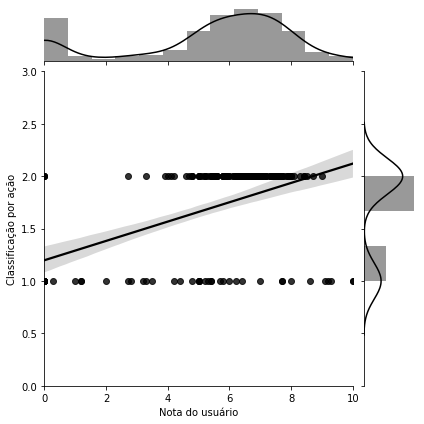

In [48]:
print('Coeficiente de correlação: ' + str(user_all['grade'].corr(user_all['crud_pred'])))

sns.jointplot(x='grade',y='crud_pred',data=user_all, kind='reg', color='k', dropna=True)

plt.xlabel('Nota do usuário')
plt.ylabel('Classificação por ação')
plt.xlim(0,10)
plt.ylim(0,3)

plt.show()

Gráfico de correlação entre classificação de horário de ação e nota da disciplina

Coeficiente de correlação: 0.11336459510478475


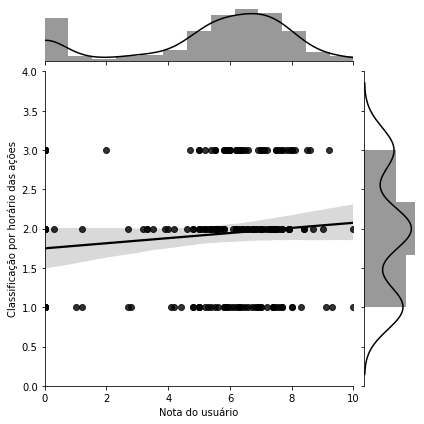

In [49]:
print('Coeficiente de correlação: ' + str(user_all['grade'].corr(user_all['time_pred'])))

sns.jointplot(x='grade',y='time_pred',data=user_all, kind='reg', color='k', dropna=True)
plt.xlabel('Nota do usuário')
plt.ylabel('Classificação por horário das ações')
plt.xlim(0,10)
plt.ylim(0,4)

plt.show()

Surpreendente, houve pouca correlação entre os grupos separados por tempo de uso do Moodle (dia, mês e horário) e as notas finais dos alunos, encontrando um coeficiente de aproximadamente 0,11. Assim, ao contrário do que se poderia especular, não há indícios de que o uso de horário do Moodle (que poderia indicar um horário preferido de estudo) está relacionado com as notas finais dos alunos. Por outro lado, encontrou-se um coeficiente de correlação de 0,53 entre grupos separados por tipo de ação realizada e nota final da disciplina. Este valor está muito aproximado do coeficiente de correlação entre tempo total no Moodle e nota final da disciplina (realizado em outro notebook, obtendo coefiente de 0,51). Pode-se especular que alunos que ficam mais tempo no Moodle realizam mais ações (ou mais cliques), e este uso irá impactar sua nota final.
